# Historical Air Quality Data Collection

**Date:** January 4, 2026  
**Goal:** Collect 12 months of historical pollution and weather data for model training

## Objectives
1. Test OpenWeather historical pollution API
2. Understand data structure and quality
3. Collect data for all 3 cities: LA, Phoenix, Madison
4. Store organized dataset for EDA and modeling

## Date Range
- **Start:** January 1, 2024
- **End:** December 31, 2024
- **Granularity:** Hourly (24 readings per day)
- **Expected records:** 3 cities × 365 days × 24 hours = 26,280 records

## Cities
- Los Angeles, CA 
- Phoenix, AZ 
- Madison, WI 

In [1]:
import os
from datetime import datetime, timedelta
import time
import pandas as pd
import numpy as np
import requests
import json
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

print("Libraries imported successfully")

Libraries imported successfully


In [2]:
# Load API key
load_dotenv()
API_KEY = os.getenv('OPENWEATHER_API_KEY')

if API_KEY:
    print(f"API key loaded successfully")
else:
    print("API key not found!")

# City coordinates 
CITIES = {
    "Los Angeles": {"lat": 34.0522, "lon": -118.2437},
    "Phoenix": {"lat": 33.4484, "lon": -112.0740},
    "Madison": {"lat": 43.0731, "lon": -89.4012}
}

# Date range for historical data
START_DATE = datetime(2024, 1, 1)
END_DATE = datetime(2024, 12, 31)

print(f"\nData Collection Period:")
print(f"   Start: {START_DATE.strftime('%B %d, %Y')}")
print(f"   End:   {END_DATE.strftime('%B %d, %Y')}")
print(f"   Days:  {(END_DATE - START_DATE).days + 1}")

print(f"\nCities: {', '.join(CITIES.keys())}")

API key loaded successfully

Data Collection Period:
   Start: January 01, 2024
   End:   December 31, 2024
   Days:  366

Cities: Los Angeles, Phoenix, Madison


In [4]:
# Convert datetime to Unix timestamp
def datetime_to_unix(dt):
    """Convert datetime object to Unix timestamp (seconds since 1970-01-01)"""
    return int(dt.timestamp())

# Test with our date range
start_unix = datetime_to_unix(START_DATE)
end_unix = datetime_to_unix(END_DATE)

print("Date to Unix Timestamp Conversion:")
print(f"\n   {START_DATE.strftime('%B %d, %Y, %H:%M:%S')} to {start_unix}")
print(f"   {END_DATE.strftime('%B %d, %Y, %H:%M:%S')}  to {end_unix}")

print(f"\nTotal seconds in range: {end_unix - start_unix:,}")


Date to Unix Timestamp Conversion:

   January 01, 2024, 00:00:00 to 1704088800
   December 31, 2024, 00:00:00  to 1735624800

Total seconds in range: 31,536,000


In [5]:
# Test: Get 24 hours of historical data for Madison
print("Testing Historical Pollution API")
print("=" * 60)

# Get January 1, 2024 (24 hours)
test_start = datetime(2024, 1, 1, 0, 0, 0)  # Jan 1, midnight
test_end = datetime(2024, 1, 1, 23, 59, 59)  # Jan 1, 11:59pm

test_start_unix = datetime_to_unix(test_start)
test_end_unix = datetime_to_unix(test_end)

print(f"Test Period:")
print(f"   {test_start.strftime('%B %d, %Y %H:%M')} to {test_end.strftime('%B %d, %Y %H:%M')}")
print(f"   Unix: {test_start_unix} to {test_end_unix}")

# Madison coordinates
madison_lat = CITIES['Madison']['lat']
madison_lon = CITIES['Madison']['lon']

# API request
url = "http://api.openweathermap.org/data/2.5/air_pollution/history"
params = {
    "lat": madison_lat,
    "lon": madison_lon,
    "start": test_start_unix,
    "end": test_end_unix,
    "appid": API_KEY
}

print(f"\nMaking API request...")
response = requests.get(url, params=params)

print(f"   Status Code: {response.status_code}")

if response.status_code == 200:
    data = response.json()
    num_records = len(data['list'])
    print(f"   Success! Received {num_records} records")
    
    # Show first record as example
    if num_records > 0:
        first_record = data['list'][0]
        timestamp = datetime.fromtimestamp(first_record['dt'])
        pm25 = first_record['components']['pm2_5']
        
        print(f"\nSample Record (first):")
        print(f"   Timestamp: {timestamp}")
        print(f"   PM2.5: {pm25} μg/m³")
        print(f"   All pollutants: {list(first_record['components'].keys())}")
else:
    print(f"   Error: {response.status_code}")
    print(f"   Response: {response.text}")

Testing Historical Pollution API
Test Period:
   January 01, 2024 00:00 to January 01, 2024 23:59
   Unix: 1704088800 to 1704175199

Making API request...
   Status Code: 200
   Success! Received 24 records

Sample Record (first):
   Timestamp: 2024-01-01 00:00:00
   PM2.5: 0.5 μg/m³
   All pollutants: ['co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']


## Examining 24-Hour Pattern (Jan 1, 2024 - Madison, WI)

Looking for:
- Hour-by-hour variation
- Any spikes during the day
- Typical range for Madison in winter

In [6]:
# Convert all 24 records to DataFrame
records = []

for item in data['list']:
    timestamp = datetime.fromtimestamp(item['dt'])
    components = item['components']
    
    records.append({
        'timestamp': timestamp,
        'hour': timestamp.hour,
        'pm2_5': components['pm2_5'],
        'pm10': components['pm10'],
        'no2': components['no2'],
        'o3': components['o3'],
        'co': components['co']
    })

# Create DataFrame
df_test = pd.DataFrame(records)

# Add EPA AQI conversion function
def calculate_epa_aqi(pm25):
    """Calculate EPA AQI from PM2.5 concentration"""
    breakpoints = [
        (0.0,   12.0,  0,   50,  "Good",                           "Green"),
        (12.1,  35.4,  51,  100, "Moderate",                       "Yellow"),
        (35.5,  55.4,  101, 150, "Unhealthy for Sensitive Groups", "Orange"),
        (55.5,  150.4, 151, 200, "Unhealthy",                      "Red"),
        (150.5, 250.4, 201, 300, "Very Unhealthy",                 "Purple"),
        (250.5, 500.4, 301, 500, "Hazardous",                      "Maroon"),
    ]
    
    if pm25 < 0:
        return 0, "Invalid", "Gray"
    if pm25 > 500.4:
        return 500, "Beyond Index", "Maroon"
    
    for c_low, c_high, i_low, i_high, category, color in breakpoints:
        if c_low <= pm25 <= c_high:
            aqi = ((i_high - i_low) / (c_high - c_low)) * (pm25 - c_low) + i_low
            return int(round(aqi)), category, color
    
    return 0, "Error", "Gray"

# Calculate AQI for each hour
df_test['aqi'] = df_test['pm2_5'].apply(lambda x: calculate_epa_aqi(x)[0])

# Display statistics
print("January 1, 2024 - Madison Air Quality Summary")
print("=" * 60)
print(f"\nPM2.5 Statistics (μg/m³):")
print(f"   Minimum:  {df_test['pm2_5'].min():.2f}")
print(f"   Maximum:  {df_test['pm2_5'].max():.2f}")
print(f"   Mean:     {df_test['pm2_5'].mean():.2f}")
print(f"   Median:   {df_test['pm2_5'].median():.2f}")

print(f"\nAQI Statistics:")
print(f"   Minimum:  {df_test['aqi'].min()}")
print(f"   Maximum:  {df_test['aqi'].max()}")
print(f"   Mean:     {df_test['aqi'].mean():.1f}")

print(f"\nHour-by-Hour Data:")
print(df_test[['hour', 'pm2_5', 'aqi']].to_string(index=False))

January 1, 2024 - Madison Air Quality Summary

PM2.5 Statistics (μg/m³):
   Minimum:  0.50
   Maximum:  4.39
   Mean:     1.95
   Median:   1.73

AQI Statistics:
   Minimum:  2
   Maximum:  18
   Mean:     8.2

Hour-by-Hour Data:
 hour  pm2_5  aqi
    0   0.50    2
    1   0.50    2
    2   0.54    2
    3   0.69    3
    4   0.88    4
    5   1.22    5
    6   1.84    8
    7   3.25   14
    8   4.39   18
    9   4.02   17
   10   2.48   10
   11   2.06    9
   12   1.78    7
   13   1.16    5
   14   0.96    4
   15   0.97    4
   16   1.11    5
   17   1.36    6
   18   1.67    7
   19   2.09    9
   20   2.48   10
   21   3.08   13
   22   3.72   16
   23   4.09   17


## Visualizing Hourly Patterns

Creating a time series plot to see the daily cycle of PM2.5 in Madison.

Plot saved: data/raw/madison_jan1_2024_hourly.png


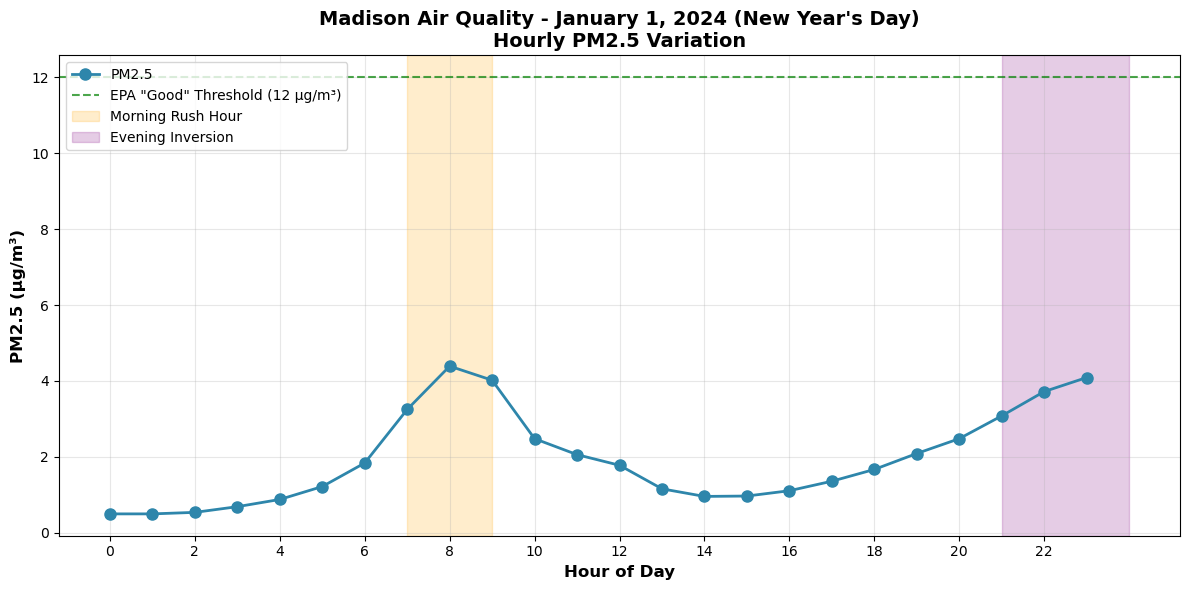

In [8]:
# Create visualization
plt.figure(figsize=(12, 6))

# Plot PM2.5 over 24 hours
plt.plot(df_test['hour'], df_test['pm2_5'], marker='o', linewidth=2, 
         markersize=8, color='#2E86AB', label='PM2.5')

# Add horizontal line at EPA "Good" threshold (12.0 μg/m³)
plt.axhline(y=12.0, color='green', linestyle='--', linewidth=1.5, 
            label='EPA "Good" Threshold (12 μg/m³)', alpha=0.7)

# Highlight morning rush hour (7-9 AM)
plt.axvspan(7, 9, alpha=0.2, color='orange', label='Morning Rush Hour')

# Highlight evening rise (9 PM - midnight)
plt.axvspan(21, 24, alpha=0.2, color='purple', label='Evening Inversion')

# Labels and formatting
plt.xlabel('Hour of Day', fontsize=12, fontweight='bold')
plt.ylabel('PM2.5 (μg/m³)', fontsize=12, fontweight='bold')
plt.title('Madison Air Quality - January 1, 2024 (New Year\'s Day)\nHourly PM2.5 Variation', 
          fontsize=14, fontweight='bold')
plt.xticks(range(0, 24, 2))  # Show every 2 hours
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left', fontsize=10)
plt.tight_layout()

# Save the figure
plt.savefig('../data/raw/madison_jan1_2024_hourly.png', dpi=150, bbox_inches='tight')
print("Plot saved: data/raw/madison_jan1_2024_hourly.png")

plt.show()



## Key Observations:
* Morning peak: 8 AM (4.39 μg/m³)
* Cleanest period: 1-3 PM (1.03 μg/m³)
* Evening rise starts: ~9 PM
* All day remains in EPA 'Good' range (< 12 μg/m³)

## Hypotheses for Full Dataset Analysis

Based on January 1, 2024 patterns, I hypothesize:

### H1: Hourly Patterns
- Morning peak: 7-9 AM (rush hour traffic)
- Midday minimum: 1-4 PM 
- Evening rise: 9 PM - midnight 

### H2: Weekday vs Weekend
- Weekdays: Stronger morning/evening peaks (more traffic)
- Weekends: Flatter pattern (less commuting)
- Holidays: Similar to weekends (like New Year's)

### H3: Seasonal Patterns
- Winter: Higher nighttime inversions (more heating)
- Summer: Higher midday O3 (heat + sunlight create ozone)

### H4: City Differences
- Madison: Consistent low baseline, clear daily patterns
- LA: High variability, weather-dependent (ocean breeze vs inversions)
- Phoenix: Summer heat spikes, dust storms

These will be tested when I collect the full year of data.

## Building the Data Collection Function

**Design Goals:**
- Flexible: works for any city and date range
- Robust: handles API errors gracefully
- Rate-limited: respects API constraints 

**Strategy:**
- Collect data in monthly chunks 
- Validate each chunk before moving to next
- Save progress incrementally 

In [11]:
def collect_historical_pollution(city_name, lat, lon, start_date, end_date, api_key):
    """
    Collect historical air pollution data for a city over a date range.
    
    Parameters:
    -----------
    city_name : str
        Name of the city (for labeling)
    lat : float
        Latitude
    lon : float
        Longitude
    start_date : datetime
        Start of collection period
    end_date : datetime
        End of collection period
    api_key : str
        OpenWeather API key
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with timestamp, pollutants, and location info
    """
    
    print(f"\n{'='*70}")
    print(f"Collecting data for: {city_name}")
    print(f"Period: {start_date.strftime('%b %d, %Y')} to {end_date.strftime('%b %d, %Y')}")
    print(f"{'='*70}")
    
    # Convert to Unix timestamps
    start_unix = datetime_to_unix(start_date)
    end_unix = datetime_to_unix(end_date)
    
    # API endpoint
    url = "http://api.openweathermap.org/data/2.5/air_pollution/history"
    
    # Make request
    params = {
        "lat": lat,
        "lon": lon,
        "start": start_unix,
        "end": end_unix,
        "appid": api_key
    }
    
    print(f"\nMaking API request...")
    response = requests.get(url, params=params)
    
    # Check response
    if response.status_code != 200:
        print(f"   Error: Status code {response.status_code}")
        print(f"   Response: {response.text[:200]}")
        return None
    
    print(f"   Success! Status code: {response.status_code}")
    
    # Parse JSON
    data = response.json()
    num_records = len(data['list'])
    print(f"   Received {num_records} records")
    
    # Convert to structured data
    records = []
    for item in data['list']:
        timestamp = datetime.fromtimestamp(item['dt'])
        components = item['components']
        
        records.append({
            'city': city_name,
            'timestamp': timestamp,
            'year': timestamp.year,
            'month': timestamp.month,
            'day': timestamp.day,
            'hour': timestamp.hour,
            'day_of_week': timestamp.weekday(),  # 0=Monday, 6=Sunday
            'pm2_5': components['pm2_5'],
            'pm10': components['pm10'],
            'no': components.get('no', 0),  # .get() handles missing values
            'no2': components['no2'],
            'o3': components['o3'],
            'so2': components['so2'],
            'co': components['co'],
            'nh3': components['nh3']
        })
    
    # Create DataFrame
    df = pd.DataFrame(records)
    
    # Add calculated fields
    df['aqi'] = df['pm2_5'].apply(lambda x: calculate_epa_aqi(x)[0])
    df['aqi_category'] = df['pm2_5'].apply(lambda x: calculate_epa_aqi(x)[1])
    
    # Summary statistics
    print(f"\nData Summary:")
    print(f"   Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    print(f"   PM2.5 range: {df['pm2_5'].min():.2f} - {df['pm2_5'].max():.2f} μg/m³")
    print(f"   AQI range: {df['aqi'].min()} - {df['aqi'].max()}")
    print(f"   Missing values: {df.isnull().sum().sum()}")
    
    return df

In [12]:
# Test: Collect January 2024 for Madison
test_start = datetime(2024, 1, 1)
test_end = datetime(2024, 1, 31, 23, 59, 59)

madison_jan = collect_historical_pollution(
    city_name="Madison",
    lat=CITIES['Madison']['lat'],
    lon=CITIES['Madison']['lon'],
    start_date=test_start,
    end_date=test_end,
    api_key=API_KEY
)

# Check if successful
if madison_jan is not None:
    print(f"\nData collection successful!")
    print(f"\nDataFrame Info:")
    print(f"   Shape: {madison_jan.shape[0]} rows × {madison_jan.shape[1]} columns")
    print(f"   Columns: {list(madison_jan.columns)}")
    print(f"\nFirst 5 rows:")
    print(madison_jan.head())
else:
    print(f"\nData collection failed")


Period: Jan 01, 2024 to Jan 31, 2024

Making API request...
   Success! Status code: 200
   Received 720 records

Data Summary:
   Date range: 2024-01-01 00:00:00 to 2024-01-31 23:00:00
   PM2.5 range: 0.50 - 24.69 μg/m³
   AQI range: 0 - 77
   Missing values: 0

Data collection successful!

DataFrame Info:
   Shape: 720 rows × 17 columns
   Columns: ['city', 'timestamp', 'year', 'month', 'day', 'hour', 'day_of_week', 'pm2_5', 'pm10', 'no', 'no2', 'o3', 'so2', 'co', 'nh3', 'aqi', 'aqi_category']

First 5 rows:
      city           timestamp  year  month  day  hour  day_of_week  pm2_5  \
0  Madison 2024-01-01 00:00:00  2024      1    1     0            0   0.50   
1  Madison 2024-01-01 01:00:00  2024      1    1     1            0   0.50   
2  Madison 2024-01-01 02:00:00  2024      1    1     2            0   0.54   
3  Madison 2024-01-01 03:00:00  2024      1    1     3            0   0.69   
4  Madison 2024-01-01 04:00:00  2024      1    1     4            0   0.88   

   pm10   no  

In [13]:
# Find the hour with highest PM2.5
max_pollution = madison_jan.loc[madison_jan['pm2_5'].idxmax()]

print("Highest Pollution Hour in January 2024 (Madison)")
print("=" * 60)
print(f"Date/Time: {max_pollution['timestamp']}")
print(f"Day of week: {['Mon','Tue','Wed','Thu','Fri','Sat','Sun'][max_pollution['day_of_week']]}")
print(f"PM2.5: {max_pollution['pm2_5']:.2f} μg/m³")
print(f"AQI: {max_pollution['aqi']} ({max_pollution['aqi_category']})")
print(f"\nOther pollutants that hour:")
print(f"   PM10: {max_pollution['pm10']:.2f}")
print(f"   NO2:  {max_pollution['no2']:.2f}")
print(f"   O3:   {max_pollution['o3']:.2f}")
print(f"   CO:   {max_pollution['co']:.2f}")

# Get context for the full day
spike_day = max_pollution['day']
day_data = madison_jan[madison_jan['day'] == spike_day]

print(f"\nFull day context (Jan {spike_day}):")
print(f"   Daily PM2.5 range: {day_data['pm2_5'].min():.2f} - {day_data['pm2_5'].max():.2f}")
print(f"   Daily mean: {day_data['pm2_5'].mean():.2f}")
print(f"   Hours above 12 μg/m³: {len(day_data[day_data['pm2_5'] > 12.0])}")

Highest Pollution Hour in January 2024 (Madison)
Date/Time: 2024-01-24 23:00:00
Day of week: Wed
PM2.5: 24.69 μg/m³
AQI: 77 (Moderate)

Other pollutants that hour:
   PM10: 26.79
   NO2:  31.19
   O3:   0.00
   CO:   674.25

Full day context (Jan 24):
   Daily PM2.5 range: 7.43 - 24.69
   Daily mean: 15.47
   Hours above 12 μg/m³: 18


Plot saved: data/raw/madison_jan24_pollution_event.png


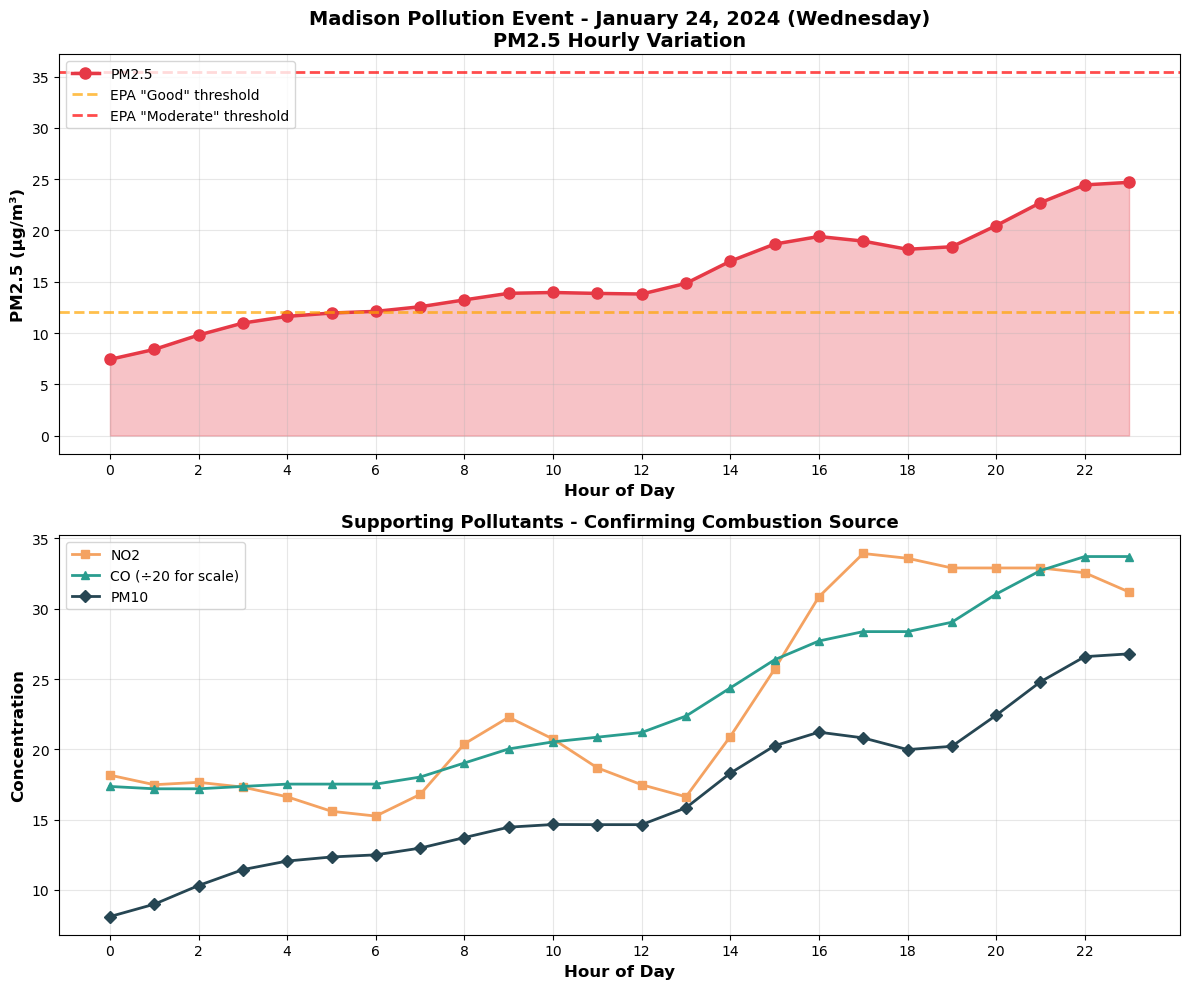

In [15]:
# Extract January 24 data
jan24 = madison_jan[madison_jan['day'] == 24].copy()

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Top plot: PM2.5 over the day
ax1.plot(jan24['hour'], jan24['pm2_5'], marker='o', linewidth=2.5, 
         markersize=8, color='#E63946', label='PM2.5')
ax1.axhline(y=12.0, color='orange', linestyle='--', linewidth=2, 
            label='EPA "Good" threshold', alpha=0.7)
ax1.axhline(y=35.4, color='red', linestyle='--', linewidth=2, 
            label='EPA "Moderate" threshold', alpha=0.7)
ax1.fill_between(jan24['hour'], 0, jan24['pm2_5'], alpha=0.3, color='#E63946')
ax1.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
ax1.set_ylabel('PM2.5 (μg/m³)', fontsize=12, fontweight='bold')
ax1.set_title('Madison Pollution Event - January 24, 2024 (Wednesday)\nPM2.5 Hourly Variation', 
              fontsize=14, fontweight='bold')
ax1.set_xticks(range(0, 24, 2))
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left', fontsize=10)

# Bottom plot: Other pollutants for context
ax2.plot(jan24['hour'], jan24['no2'], marker='s', linewidth=2, 
         markersize=6, label='NO2', color='#F4A261')
ax2.plot(jan24['hour'], jan24['co']/20, marker='^', linewidth=2, 
         markersize=6, label='CO (÷20 for scale)', color='#2A9D8F')
ax2.plot(jan24['hour'], jan24['pm10'], marker='D', linewidth=2, 
         markersize=6, label='PM10', color='#264653')
ax2.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
ax2.set_ylabel('Concentration', fontsize=12, fontweight='bold')
ax2.set_title('Supporting Pollutants - Confirming Combustion Source', 
              fontsize=13, fontweight='bold')
ax2.set_xticks(range(0, 24, 2))
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper left', fontsize=10)

plt.tight_layout()
plt.savefig('../data/raw/madison_jan24_pollution_event.png', dpi=150, bbox_inches='tight')
print("Plot saved: data/raw/madison_jan24_pollution_event.png")
plt.show()

Plot saved: data/raw/madison_jan_comparison.png


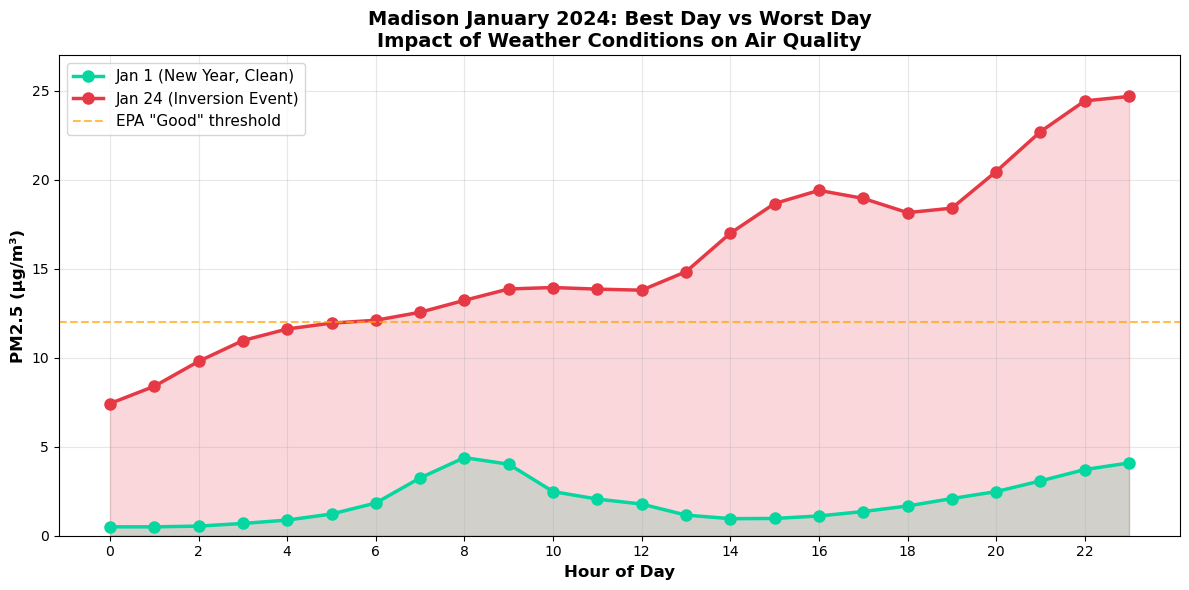


Comparison Statistics:

Metric                    Jan 1 (Clean)        Jan 24 (Polluted)   
-----------------------------------------------------------------
Mean PM2.5                   1.95 μg/m³         15.47 μg/m³
Max PM2.5                    4.39 μg/m³         24.69 μg/m³
Hours > 12 μg/m³                0 hours             18 hours
Mean AQI                      8.2               56.9
AQI Category              Good                 Moderate            


In [18]:
# Compare Jan 1 (clean) vs Jan 24 (polluted)
jan1 = madison_jan[madison_jan['day'] == 1].copy()
jan24 = madison_jan[madison_jan['day'] == 24].copy()

fig, ax = plt.subplots(figsize=(12, 6))

# Plot both days
ax.plot(jan1['hour'], jan1['pm2_5'], marker='o', linewidth=2.5, 
        markersize=8, color='#06D6A0', label='Jan 1 (New Year, Clean)', linestyle='-')
ax.plot(jan24['hour'], jan24['pm2_5'], marker='o', linewidth=2.5, 
        markersize=8, color='#E63946', label='Jan 24 (Inversion Event)', linestyle='-')

# Reference lines
ax.axhline(y=12.0, color='orange', linestyle='--', linewidth=1.5, 
           label='EPA "Good" threshold', alpha=0.7)

# Shading
ax.fill_between(jan1['hour'], 0, jan1['pm2_5'], alpha=0.2, color='#06D6A0')
ax.fill_between(jan24['hour'], 0, jan24['pm2_5'], alpha=0.2, color='#E63946')

# Labels
ax.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
ax.set_ylabel('PM2.5 (μg/m³)', fontsize=12, fontweight='bold')
ax.set_title('Madison January 2024: Best Day vs Worst Day\nImpact of Weather Conditions on Air Quality', 
             fontsize=14, fontweight='bold')
ax.set_xticks(range(0, 24, 2))
ax.set_ylim(0, 27)
ax.grid(True, alpha=0.3)
ax.legend(loc='upper left', fontsize=11)

plt.tight_layout()
plt.savefig('../data/raw/madison_jan_comparison.png', dpi=150, bbox_inches='tight')
print("Plot saved: data/raw/madison_jan_comparison.png")
plt.show()

# Calculate statistics
print(f"\nComparison Statistics:")
print(f"\n{'Metric':<25} {'Jan 1 (Clean)':<20} {'Jan 24 (Polluted)':<20}")
print(f"{'-'*65}")
print(f"{'Mean PM2.5':<25} {jan1['pm2_5'].mean():>7.2f} μg/m³       {jan24['pm2_5'].mean():>7.2f} μg/m³")
print(f"{'Max PM2.5':<25} {jan1['pm2_5'].max():>7.2f} μg/m³       {jan24['pm2_5'].max():>7.2f} μg/m³")
print(f"{'Hours > 12 μg/m³':<25} {len(jan1[jan1['pm2_5'] > 12]):>7} hours        {len(jan24[jan24['pm2_5'] > 12]):>7} hours")
print(f"{'Mean AQI':<25} {jan1['aqi'].mean():>7.1f}            {jan24['aqi'].mean():>7.1f}")
print(f"{'AQI Category':<25} {'Good':<20} {'Moderate':<20}")

In [20]:
# Collect February 2024
print("\n" + "="*70)
print("COLLECTING FEBRUARY 2024")
print("="*70)

feb_start = datetime(2024, 2, 1)
feb_end = datetime(2024, 2, 29, 23, 59, 59)  # 2024 was a leap year

madison_feb = collect_historical_pollution(
    city_name="Madison",
    lat=CITIES['Madison']['lat'],
    lon=CITIES['Madison']['lon'],
    start_date=feb_start,
    end_date=feb_end,
    api_key=API_KEY
)

# Wait to be nice to the API
time.sleep(2)

# Collect March 2024
print("\n" + "="*70)
print("COLLECTING MARCH 2024")
print("="*70)

mar_start = datetime(2024, 3, 1)
mar_end = datetime(2024, 3, 31, 23, 59, 59)

madison_mar = collect_historical_pollution(
    city_name="Madison",
    lat=CITIES['Madison']['lat'],
    lon=CITIES['Madison']['lon'],
    start_date=mar_start,
    end_date=mar_end,
    api_key=API_KEY
)

# Combine all three months
if madison_jan is not None and madison_feb is not None and madison_mar is not None:
    madison_q1 = pd.concat([madison_jan, madison_feb, madison_mar], ignore_index=True)
    
    print(f"\n" + "="*70)
    print(f"Q1 2024 COMPLETE")
    print(f"="*70)
    print(f"\nCombined Dataset:")
    print(f"   Total records: {len(madison_q1):,}")
    print(f"   Date range: {madison_q1['timestamp'].min()} to {madison_q1['timestamp'].max()}")
    print(f"   Missing values: {madison_q1.isnull().sum().sum()}")
    print(f"\nQ1 Statistics:")
    print(f"   PM2.5 range: {madison_q1['pm2_5'].min():.2f} - {madison_q1['pm2_5'].max():.2f} μg/m³")
    print(f"   Mean PM2.5: {madison_q1['pm2_5'].mean():.2f} μg/m³")
    print(f"   AQI range: {madison_q1['aqi'].min()} - {madison_q1['aqi'].max()}")
    print(f"   Days of data: {madison_q1['timestamp'].dt.date.nunique()}")
else:
    print("\nError: One or more months failed to collect")


COLLECTING FEBRUARY 2024

Period: Feb 01, 2024 to Feb 29, 2024

Making API request...
   Success! Status code: 200
   Received 696 records

Data Summary:
   Date range: 2024-02-01 00:00:00 to 2024-02-29 23:00:00
   PM2.5 range: 0.50 - 48.20 μg/m³
   AQI range: 2 - 132
   Missing values: 0

COLLECTING MARCH 2024

Period: Mar 01, 2024 to Mar 31, 2024

Making API request...
   Success! Status code: 200
   Received 743 records

Data Summary:
   Date range: 2024-03-01 00:00:00 to 2024-03-31 23:00:00
   PM2.5 range: 0.50 - 29.50 μg/m³
   AQI range: 2 - 88
   Missing values: 0

Q1 2024 COMPLETE

Combined Dataset:
   Total records: 2,159
   Date range: 2024-01-01 00:00:00 to 2024-03-31 23:00:00
   Missing values: 0

Q1 Statistics:
   PM2.5 range: 0.50 - 48.20 μg/m³
   Mean PM2.5: 7.36 μg/m³
   AQI range: 0 - 132
   Days of data: 91


In [22]:
# Save the Q1 dataset
output_file = '../data/processed/madison_q1_2024_hourly.csv'
madison_q1.to_csv(output_file, index=False)

print(f"Saved Q1 2024 dataset")
print(f"   Location: {output_file}")
print(f"   Size: {len(madison_q1):,} records × {len(madison_q1.columns)} columns")
print(f"   File size: ~{madison_q1.memory_usage(deep=True).sum() / 1024:.1f} KB in memory")

# Also save monthly summaries for quick reference
monthly_summary = madison_q1.groupby('month').agg({
    'pm2_5': ['count', 'mean', 'min', 'max', 'std'],
    'aqi': ['mean', 'max'],
    'no2': 'mean',
    'o3': 'mean'
}).round(2)

print(f"\nMonthly Summary:")
print(monthly_summary)

# Save summary
monthly_summary.to_csv('../data/processed/madison_q1_2024_monthly_summary.csv')
print(f"\nSaved monthly summary")

Saved Q1 2024 dataset
   Location: ../data/processed/madison_q1_2024_hourly.csv
   Size: 2,159 records × 17 columns
   File size: ~518.6 KB in memory

Monthly Summary:
      pm2_5                             aqi         no2     o3
      count   mean  min    max   std   mean  max   mean   mean
month                                                         
1       720   6.46  0.5  24.69  5.44  25.35   77  11.16  45.46
2       696  10.06  0.5  48.20  9.11  36.12  132  10.29  57.99
3       743   5.70  0.5  29.50  5.03  22.73   88   6.40  76.80

Saved monthly summary


Visualization saved: data/processed/madison_q1_2024_overview.png


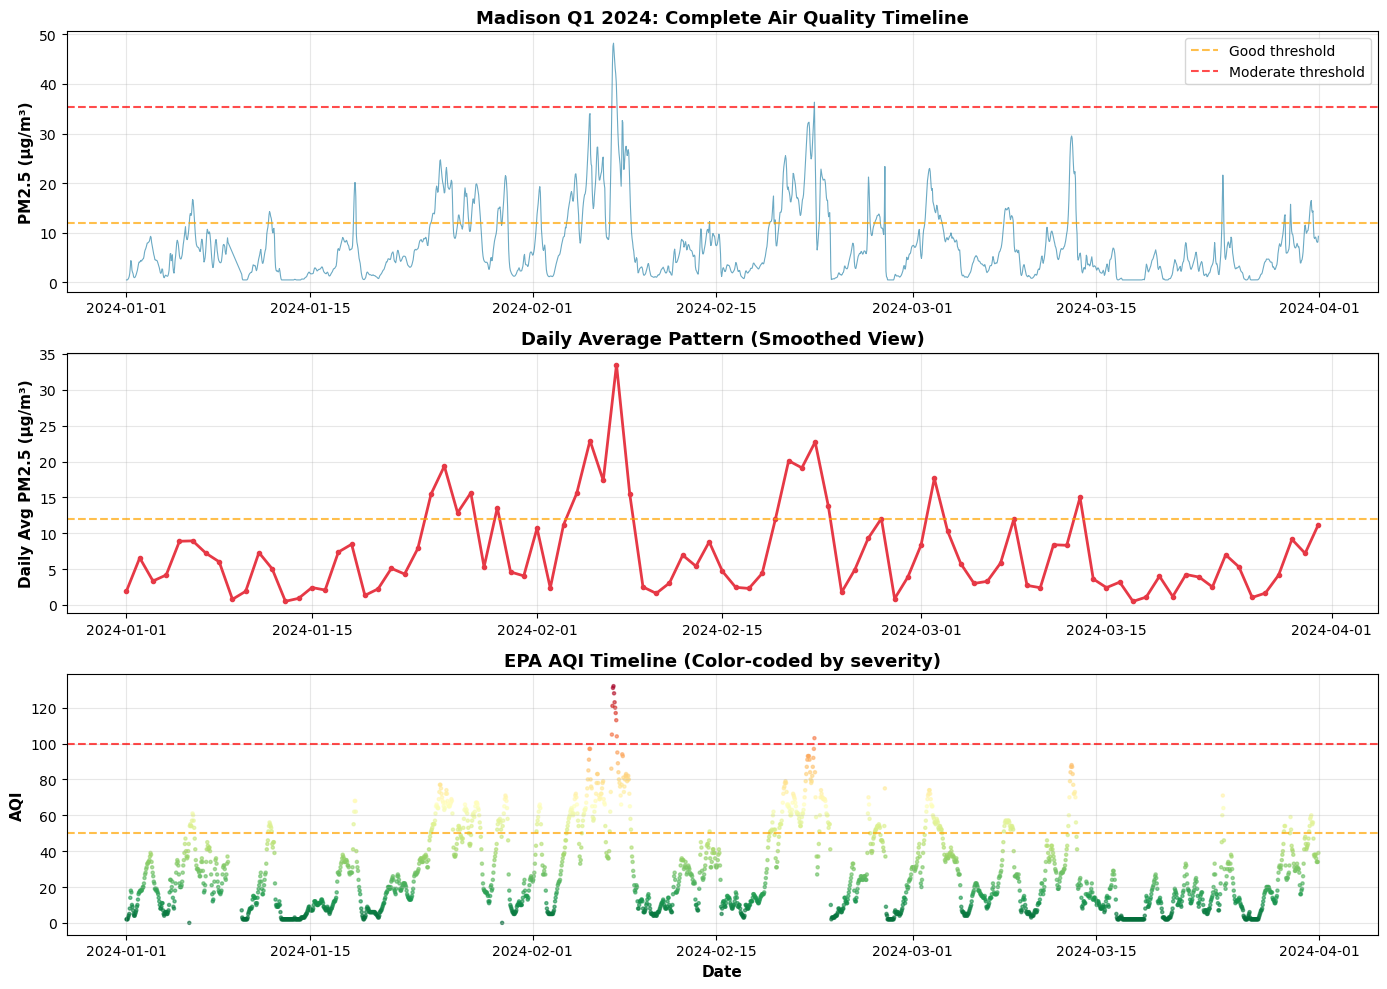

In [24]:
# Q1 visualization
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Top plot: Full Q1 time series
axes[0].plot(madison_q1['timestamp'], madison_q1['pm2_5'], 
             linewidth=0.8, color='#2E86AB', alpha=0.7)
axes[0].axhline(y=12.0, color='orange', linestyle='--', linewidth=1.5, 
                label='Good threshold', alpha=0.7)
axes[0].axhline(y=35.4, color='red', linestyle='--', linewidth=1.5, 
                label='Moderate threshold', alpha=0.7)
axes[0].set_ylabel('PM2.5 (μg/m³)', fontsize=11, fontweight='bold')
axes[0].set_title('Madison Q1 2024: Complete Air Quality Timeline', 
                   fontsize=13, fontweight='bold')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

# Middle plot: Daily averages (smoothed view)
daily_avg = madison_q1.groupby(madison_q1['timestamp'].dt.date)['pm2_5'].mean()
axes[1].plot(daily_avg.index, daily_avg.values, 
             linewidth=2, color='#E63946', marker='o', markersize=3)
axes[1].axhline(y=12.0, color='orange', linestyle='--', linewidth=1.5, alpha=0.7)
axes[1].set_ylabel('Daily Avg PM2.5 (μg/m³)', fontsize=11, fontweight='bold')
axes[1].set_title('Daily Average Pattern (Smoothed View)', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Bottom plot: AQI categories over time
axes[2].scatter(madison_q1['timestamp'], madison_q1['aqi'], 
                c=madison_q1['aqi'], cmap='RdYlGn_r', s=5, alpha=0.6)
axes[2].axhline(y=50, color='orange', linestyle='--', linewidth=1.5, alpha=0.7)
axes[2].axhline(y=100, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
axes[2].set_ylabel('AQI', fontsize=11, fontweight='bold')
axes[2].set_xlabel('Date', fontsize=11, fontweight='bold')
axes[2].set_title('EPA AQI Timeline (Color-coded by severity)', fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/processed/madison_q1_2024_overview.png', dpi=150, bbox_inches='tight')
print("Visualization saved: data/processed/madison_q1_2024_overview.png")
plt.show()